# Bayesian model reduction and laplace approximation

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(context='notebook', style='white', font_scale=1.6, color_codes=True)

In [2]:
import equinox as eqx
import jax.numpy as jnp
import numpyro.distributions as dist
from jax import random, nn, vmap
from functools import partial
import optax

from models import exact_blr, log_ratio, BayesRegression, SVIRegression, BMRRegression, LinearizedRegression

## Reparametrization

$$ F = \int Q(x|\sigma) \ln \frac{Q(x|\sigma)}{P(o|x)P(x|\sigma)} dx $$
$$\int d x Q(x|\sigma) \ln Q(x|\sigma) = - \frac{1}{2} \ln |2\pi e \sigma^2 \Sigma| = - \frac{1}{2}\ln |2 \pi e \Sigma| - D \ln \sigma $$
$$ \ln P(o|x) = \ln P(o| x \cdot u) $$
$$ - \int d x Q(x|\sigma) \ln P(x|\sigma) = \frac{1}{2} \left[ \frac{\mu^T \mu}{\sigma^2} 
 + \Sigma \right]  + D \ln \sigma$$

Free energy as computed via reparametrization tranform
$$ x = \mu + \sigma \epsilon $$
$$ \ln P(o|\epsilon) = \ln P(o| \mu \cdot u + \sigma \epsilon \cdot u)$$

$$ F = \int Q(\epsilon) \ln \frac{Q(\epsilon)}{P(o|\epsilon) P(\epsilon|\sigma)}$$
$$ \int d\epsilon Q(\epsilon) \ln Q(\epsilon) = -\frac{1}{2}\ln |2\pi e \Sigma| $$
$$ - \int d\epsilon Q(\epsilon)\ln P(\epsilon|\sigma) = \frac{1}{2} \Sigma  + D \ln \sigma$$

In [3]:
def plot_posteriors(posterior_smpls):
    fig, axes = plt.subplots(3, 4, figsize=(16, 10), sharex=True, sharey='row')

    sns.boxenplot(posterior_smpls['nobmr']['norm'], color='b', ax=axes[0, 0], showfliers=False, outlier_prop=1e-3);
    axes[0, 0].plot(nn.one_hot(0, num_classes=D), 'rd');
    axes[0, 0].set_title('Without prunning')

    sns.boxenplot(posterior_smpls['bmr']['norm'], color='b', ax=axes[0, 1], showfliers=False, outlier_prop=1e-3);
    axes[0, 1].plot(nn.one_hot(0, num_classes=D), 'rd');
    axes[0, 1].set_title('With prunning')

    sns.boxenplot(posterior_smpls['svi']['norm'], color='b', ax=axes[0, 2], showfliers=False, outlier_prop=1e-3);
    axes[0, 2].plot(nn.one_hot(0, num_classes=D), 'rd');
    axes[0, 2].set_title('SVI')

    sns.boxenplot(posterior_smpls['mcmc']['norm'], color='b', ax=axes[0, -1], showfliers=False, outlier_prop=1e-3);
    axes[0, -1].plot(nn.one_hot(0, num_classes=D), 'rd');
    axes[0, -1].set_title('MCMC-NUTS')

    axes[0, -1].yaxis.set_label_position("right")
    axes[0, -1].set_ylabel('Linear regression', rotation=-90, fontsize=12)

    sns.boxenplot(posterior_smpls['nobmr']['bern'], color='b', ax=axes[1, 0], showfliers=False, outlier_prop=1e-3);
    axes[1, 0].plot(nn.one_hot(0, num_classes=D), 'rd');

    sns.boxenplot(posterior_smpls['bmr']['bern'], color='b', ax=axes[1, 1], showfliers=False, outlier_prop=1e-3);
    axes[1, 1].plot(nn.one_hot(0, num_classes=D), 'rd');

    sns.boxenplot(posterior_smpls['svi']['bern'], color='b', ax=axes[1, 2], showfliers=False, outlier_prop=1e-3);
    axes[1, 2].plot(nn.one_hot(0, num_classes=D), 'rd');

    sns.boxenplot(posterior_smpls['mcmc']['bern'], color='b', ax=axes[1, -1], showfliers=False, outlier_prop=1e-3);
    axes[1, -1].plot(nn.one_hot(0, num_classes=D), 'rd');

    axes[1, -1].yaxis.set_label_position("right")
    axes[1, -1].set_ylabel('Logistic regression', rotation=-90, fontsize=12)

    sns.boxenplot(posterior_smpls['nobmr']['cat'].reshape(-1, _D * 10), color='b', ax=axes[-1, 0], showfliers=False, outlier_prop=1e-3);
    axes[-1, 0].plot(nn.one_hot(jnp.arange(10), num_classes=D)[:, :10].reshape(-1), 'rd');

    sns.boxenplot(posterior_smpls['bmr']['cat'].reshape(-1, _D * 10), color='b', ax=axes[-1, 1], showfliers=False, outlier_prop=1e-3);
    axes[-1, 1].plot(nn.one_hot(jnp.arange(10), num_classes=D)[:, :10].reshape(-1), 'rd');

    sns.boxenplot(posterior_smpls['svi']['cat'].reshape(-1, _D * 10), color='b', ax=axes[-1, 2], showfliers=False, outlier_prop=1e-3);
    axes[-1, 2].plot(nn.one_hot(jnp.arange(10), num_classes=D)[:, :10].reshape(-1), 'rd');

    sns.boxenplot(posterior_smpls['mcmc']['cat'].reshape(-1, _D * 10), color='b', ax=axes[-1, -1], showfliers=False, outlier_prop=1e-3);
    axes[-1, -1].plot(nn.one_hot(jnp.arange(10), num_classes=D)[:, :10].reshape(-1), 'rd');

    axes[-1, -1].yaxis.set_label_position("right")
    axes[-1, -1].set_ylabel('Multinomial regression', rotation=-90, fontsize=12)

    axes[-1, 0].set_xticks(ticks=[]);
    axes[-1, -1].set_xticks(ticks=[]);
    fig.tight_layout()
    sns.despine(fig, bottom=True)

    return fig

In [4]:
seed = 2982666625879488464
rng_key = random.PRNGKey(seed)

D = 100
N = 100

rng_key, _rng_key = random.split(rng_key)
X_norm = random.normal(_rng_key, shape=(N, D))

rng_key, _rng_key = random.split(rng_key)
y_norm = X_norm @ nn.one_hot(0, num_classes=D) + random.normal(_rng_key, shape=(N,))

N = 2 * N
X_bern = random.normal(_rng_key, shape=(N, D))
rng_key, _rng_key = random.split(rng_key)
y_bern = random.bernoulli(_rng_key, nn.sigmoid(X_bern @ nn.one_hot(0, num_classes=D)))

_D = 10
N = 2 * N
X_cat = random.normal(_rng_key, shape=(N, _D))
rng_key, _rng_key = random.split(rng_key)
y_cat = random.categorical(_rng_key, X_cat @ nn.one_hot(jnp.arange(10), num_classes=_D).T)

## Exact Bayesian inference for normal likelihood

In [5]:
mu_n, P_n, a_n, b_n = exact_blr(X_norm, y_norm)

L_n = jnp.linalg.cholesky(jnp.linalg.inv(P_n))

params = {
    'a': a_n,
    'b': b_n,
    'mu': mu_n,
    'L': L_n,
}

rng_key, _rng_key = random.split(rng_key)
sigma_square = dist.InverseGamma(a_n, b_n).sample(_rng_key, sample_shape=(1000,))

rng_key, _rng_key = random.split(rng_key)
eps = jnp.expand_dims(jnp.sqrt(sigma_square), -1) * random.normal(_rng_key, shape=(1000, D))
betas = mu_n + (L_n @ eps.T).T

samples = {
    'beta': betas,
    'sigma': jnp.sqrt(sigma_square)
}

lr = partial(log_ratio, X_norm, y_norm, params)
print('F', vmap(lr)(samples).mean())

F 221.19566


0.117527686 0.016620925


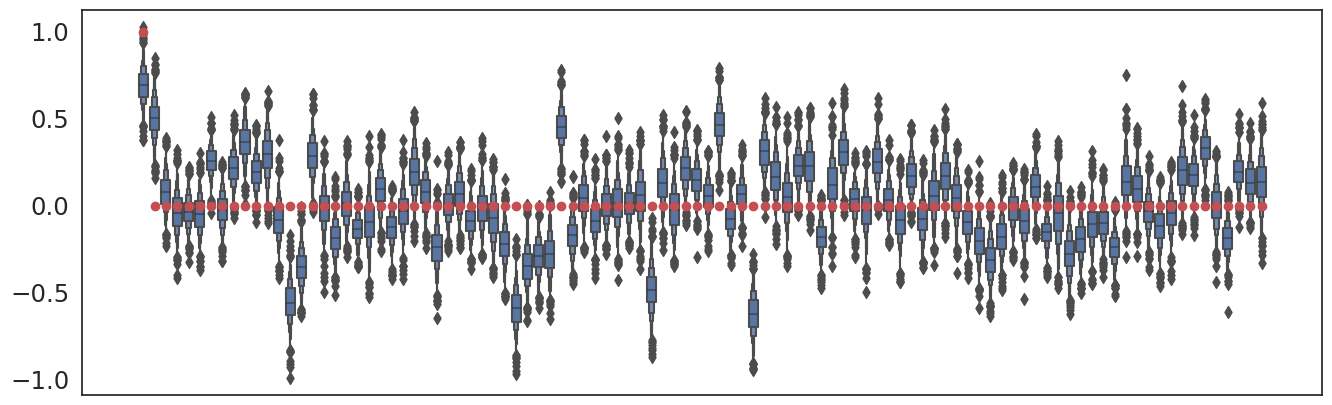

In [6]:
print( b_n/(a_n - 1), b_n/ jnp.sqrt((a_n-1)**2 * (a_n - 2)) )

plt.figure(figsize=(16, 5))
sns.boxenplot(betas, color='b');
plt.plot(nn.one_hot(0, num_classes=D), 'ro');
plt.xticks(ticks=[]);

100%|██████████| 30000/30000 [00:23<00:00, 1286.80it/s, init loss: 757.5214, avg. loss [28501-30000]: 221.8114]


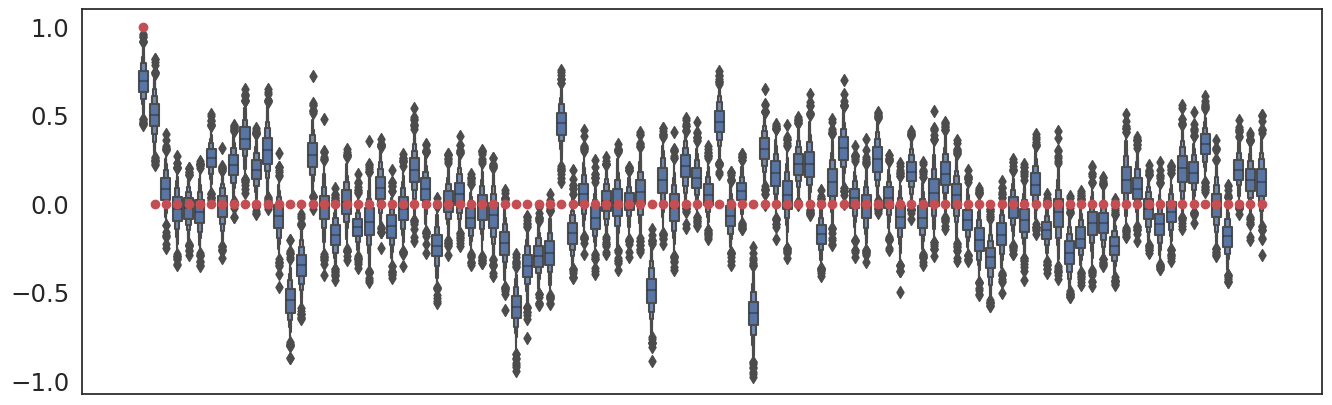

In [7]:
rng_key, _rng_key = random.split(rng_key)
linnet = eqx.nn.Sequential([eqx.nn.Linear(D, 1, use_bias=False, key=_rng_key)])

svi_reg = LinearizedRegression(_rng_key, X_norm, linnet, regtype='linear', with_hyperprior=False)
svi_smpl_norm = svi_reg.fit(
    y_norm,
    num_steps=30_000, 
    autoguide='test', 
    progress_bar=True
)
betas = svi_smpl_norm['beta']

plt.figure(figsize=(16, 5))
sns.boxenplot(betas, color='b');
plt.plot(nn.one_hot(0, num_classes=D), 'ro');
plt.xticks(ticks=[]);

100%|██████████| 30000/30000 [00:23<00:00, 1301.38it/s, init loss: 5135.9136, avg. loss [28501-30000]: 221.8597]


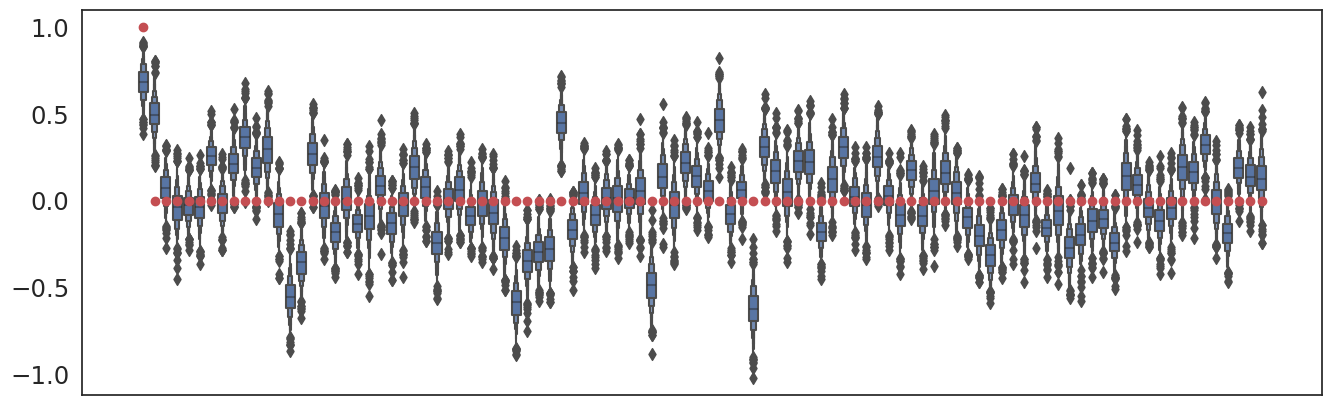

In [8]:
rng_key, _rng_key = random.split(rng_key)
linnet = eqx.nn.Sequential([eqx.nn.Linear(D, 1, use_bias=False, key=_rng_key)])

rng_key, _rng_key = random.split(rng_key)
bmr_reg = BMRRegression(_rng_key, X_norm, linnet, posterior='multivariate')
nobmr_smpl_norm = bmr_reg.fit(y_norm, num_steps=30_000, progress_bar=True)

plt.figure(figsize=(16, 5))
sns.boxenplot(nobmr_smpl_norm['beta'], color='b');
plt.plot(nn.one_hot(0, num_classes=D), 'ro');
plt.xticks(ticks=[]);

## Bayesian model reduction

Let us consider the following general regression problem
$$ y \sim  p(y| \pmb{\theta} \cdot \pmb{X}) $$
$$ p(\theta_i) = \mathcal{N}\left(0, 1 \right)$$

Given some data $\mathcal{D} = \left(y_1, \ldots, y_T\right) \equiv \pmb{y}$ the approximate posterior $p(\pmb{\theta}|\mathcal{D}) \approx Q(\pmb{\theta})$ becomes

\begin{equation}
    p\left(\pmb{\theta}| \mathcal{D} \right) = \mathcal{N}\left(\pmb{\mu}_n, \pmb{P}_n^{-1} \right)
\end{equation}

Our reduced prior over coeficients $\pmb{\theta}$ will have the following form

$$ \tilde{p}(\theta_i) = \mathcal{N}\left( 0, \gamma_i^2 \right), \qquad \gamma_i^2 = \frac{\tau_0^2 c^2 \tau^2\lambda_i^2}{c^2 + \tau_0^2\tau^2\lambda_i^2}$$ 

where $\tau^2 \lambda_i^2 \geq 0$. The change in the variational free energy is obtained as 

$$ \Delta F = \ln E_{Q(\pmb{\theta})}\left[ \frac{\tilde{p}(\pmb{\theta})}{p(\pmb{\theta})}\right] =  - \frac{1}{2} \ln |\pmb{G} + [\pmb{I} - \pmb{G}] \cdot \pmb{P}_n^{-1}| -\frac{1}{2} \pmb{\mu}_n^T \pmb{P}_n \pmb{\mu}_n + \frac{1}{2} \tilde{\pmb{\mu}}_n^T \tilde{\pmb{P}}_n \tilde{\mu}_n $$
where $ \pmb{G} = diag(\pmb{\gamma}^2)$.

## Nonlinear regression
$$ f(X) = {W}_2 \cdot ReLU(\pmb{W}_1 \cdot X)$$
$$ y \sim p\left(y| f(\pmb{X}), \pmb{\Theta}\right)$$

$$ p(W_1, W_2| \mathcal{D} ) \approx \prod_{ij} q(w^1_{ij}) \prod_{km} q(w^2_{ij})$$ 

In [9]:
seed = 29826666258
rng_key = random.PRNGKey(seed)

_D = 10
D = 100
N = 2000

rng_key, _rng_key = random.split(rng_key)
X_norm = random.normal(_rng_key, shape=(N, D))

hidden_dim = 2 * _D - 1
W1 = jnp.pad(nn.one_hot(jnp.arange(hidden_dim), num_classes=hidden_dim), ((0, D - hidden_dim), (0, 0)))
W2 = nn.one_hot(0, num_classes=hidden_dim)
rng_key, _rng_key = random.split(rng_key)
y_norm = nn.relu(X_norm @ W1) @ W2 + random.normal(_rng_key, shape=(N,))

X_bern = random.normal(_rng_key, shape=(N, D))
rng_key, _rng_key = random.split(rng_key)
y_bern = random.bernoulli(_rng_key, nn.sigmoid(nn.relu(X_bern @ W1) @ W2))

hidden_dim = D
rng_key, _rng_key = random.split(rng_key)
X_cat = random.normal(_rng_key, shape=(N, _D))
W1 = nn.one_hot(jnp.arange(_D), num_classes=hidden_dim)
W2 = nn.one_hot(jnp.arange(10), num_classes=hidden_dim).T
rng_key, _rng_key = random.split(rng_key)
y_cat = random.categorical(_rng_key, nn.relu(X_cat @ W1) @ W2)

In [10]:
nonlin_posterior = {
    'nobmr': {},
    'bmr': {},
    'svi': {},
    'mcmc': {}
}

hidden_dim = 2 * _D - 1
rng_key, _rng_key = random.split(rng_key)
nnet1 = eqx.nn.MLP(D, 1, hidden_dim, 1, use_bias=False, key=_rng_key)

hidden_dim = D
rng_key, _rng_key = random.split(rng_key)
nnet2 = eqx.nn.MLP(_D, 10, hidden_dim, 1, use_bias=False, key=_rng_key)

## No-U-turn sampler

In [19]:
rng_key, _rng_key = random.split(rng_key)
bayes_reg = BayesRegression(_rng_key, X_norm, nnet1)
smpl_norm = bayes_reg.fit(
    y_norm, 
    num_samples=250, 
    warmup_steps=1000, 
    num_chains=4,
    progress_bar=True
)

nonlin_posterior['mcmc']['norm'] = smpl_norm['beta']

sample: 100%|██████████| 1250/1250 [03:04<00:00,  6.78it/s]


In [20]:
rng_key, _rng_key = random.split(rng_key)
bayes_reg = BayesRegression(_rng_key, X_bern, nnet1, regtype='logistic')
smpl_bern = bayes_reg.fit(
    y_bern, 
    num_samples=250, 
    warmup_steps=1000, 
    num_chains=4, 
    progress_bar=True
)
nonlin_posterior['mcmc']['bern'] = smpl_bern['beta']


sample: 100%|██████████| 1250/1250 [01:30<00:00, 13.75it/s]


In [21]:
rng_key, _rng_key = random.split(rng_key)
bayes_reg = BayesRegression(_rng_key, X_cat, nnet2, regtype='multinomial')
smpl_cat = bayes_reg.fit(
    y_cat, 
    num_samples=250, 
    warmup_steps=1000, 
    num_chains=4, 
    progress_bar=True
)
nonlin_posterior['mcmc']['cat'] = smpl_cat['beta']

sample: 100%|██████████| 1250/1250 [03:26<00:00,  6.05it/s]


## Stochastic variational inference

In [22]:
rng_key, _rng_key = random.split(rng_key)
svi_reg = SVIRegression(_rng_key, X_norm, nnet1)
svi_smpl_norm = svi_reg.fit(
    y_norm, 
    num_steps=50_000, 
    autoguide='mean-field', 
    progress_bar=True
)
nonlin_posterior['svi']['norm'] = svi_smpl_norm['beta']

100%|██████████| 50000/50000 [01:17<00:00, 641.41it/s, init loss: 21968.5742, avg. loss [47501-50000]: 3432.0593]


In [23]:
rng_key, _rng_key = random.split(rng_key)
svi_reg = SVIRegression(_rng_key, X_bern, nnet1, regtype='logistic')

svi_smpl_bern = svi_reg.fit(
    y_bern, 
    num_steps=50_000, 
    autoguide='mean-field', 
    progress_bar=True
)
nonlin_posterior['svi']['bern'] = svi_smpl_bern['beta']

100%|██████████| 50000/50000 [01:13<00:00, 677.69it/s, init loss: 18851.0918, avg. loss [47501-50000]: 1926.1812]


In [24]:
rng_key, _rng_key = random.split(rng_key)
svi_reg = SVIRegression(_rng_key, X_cat, nnet2, regtype='multinomial')
svi_smpl_cat = svi_reg.fit(
    y_cat, 
    num_steps=50_000, 
    autoguide='mean-field',
    progress_bar=True
)

nonlin_posterior['svi']['cat'] = svi_smpl_cat['beta']

100%|██████████| 50000/50000 [01:18<00:00, 634.77it/s, init loss: 23587.6562, avg. loss [47501-50000]: 5147.1797]


## Bayesian model reduction

In [25]:
rng_key, _rng_key = random.split(rng_key)
bmr_reg = BMRRegression(_rng_key, X_norm, nnet1, posterior='normal')

nobmr_smpl_norm = bmr_reg.fit(
    y_norm, 
    num_steps=20_000, 
    progress_bar=True
)

nonlin_posterior['nobmr']['norm'] = nobmr_smpl_norm['beta']

100%|██████████| 20000/20000 [00:15<00:00, 1270.95it/s, init loss: 7100.0737, avg. loss [19001-20000]: 3020.3801]


In [26]:
results, bmr_smpl_norm = bmr_reg.bmr(
    'mean-field',
    num_steps=30_000, 
    progress_bar=True
)

nonlin_posterior['bmr']['norm'] = bmr_smpl_norm['beta']
print('<dF> + F: ', results.losses[-1000:].mean() + bmr_reg.results.losses[-1000:].mean())

100%|██████████| 30000/30000 [00:34<00:00, 858.35it/s, init loss: 12957.2021, avg. loss [28501-30000]: 412.3591]


<dF> + F:  3432.8555


In [27]:
rng_key, _rng_key = random.split(rng_key)
bmr_reg = BMRRegression(_rng_key, X_bern, nnet1, regtype='logistic', posterior='normal')
nobmr_smpl_bern = bmr_reg.fit(y_bern, num_steps=20_000, progress_bar=True)
nonlin_posterior['nobmr']['bern'] = nobmr_smpl_bern['beta']

results, bmr_smpl_bern = bmr_reg.bmr(
    'mean-field',
    num_steps=30_000, 
    progress_bar=True
)

nonlin_posterior['bmr']['bern'] = bmr_smpl_bern['beta']
print('<dF> + F: ', results.losses[-1000:].mean() + bmr_reg.results.losses[-1000:].mean())

100%|██████████| 30000/30000 [00:36<00:00, 820.63it/s, init loss: 12614.7305, avg. loss [28501-30000]: 494.9780]


<dF> + F:  1933.7681


In [28]:
rng_key, _rng_key = random.split(rng_key)
bmr_reg = BMRRegression(_rng_key, X_cat, nnet2, regtype='multinomial', posterior='normal')
nobmr_smpl_cat = bmr_reg.fit(y_cat, num_steps=20_000, progress_bar=True)
nonlin_posterior['nobmr']['cat'] = nobmr_smpl_cat['beta']

results, bmr_smpl_cat = bmr_reg.bmr(
    'mean-field', 
    num_steps=30_000, 
    progress_bar=True
)

nonlin_posterior['bmr']['cat'] = bmr_smpl_cat['beta']
print('<dF> + F: ', results.losses[-1000:].mean() + bmr_reg.results.losses[-1000:].mean())

100%|██████████| 30000/30000 [00:34<00:00, 878.44it/s, init loss: 11803.5225, avg. loss [28501-30000]: -2001.8403] 


<dF> + F:  5109.649


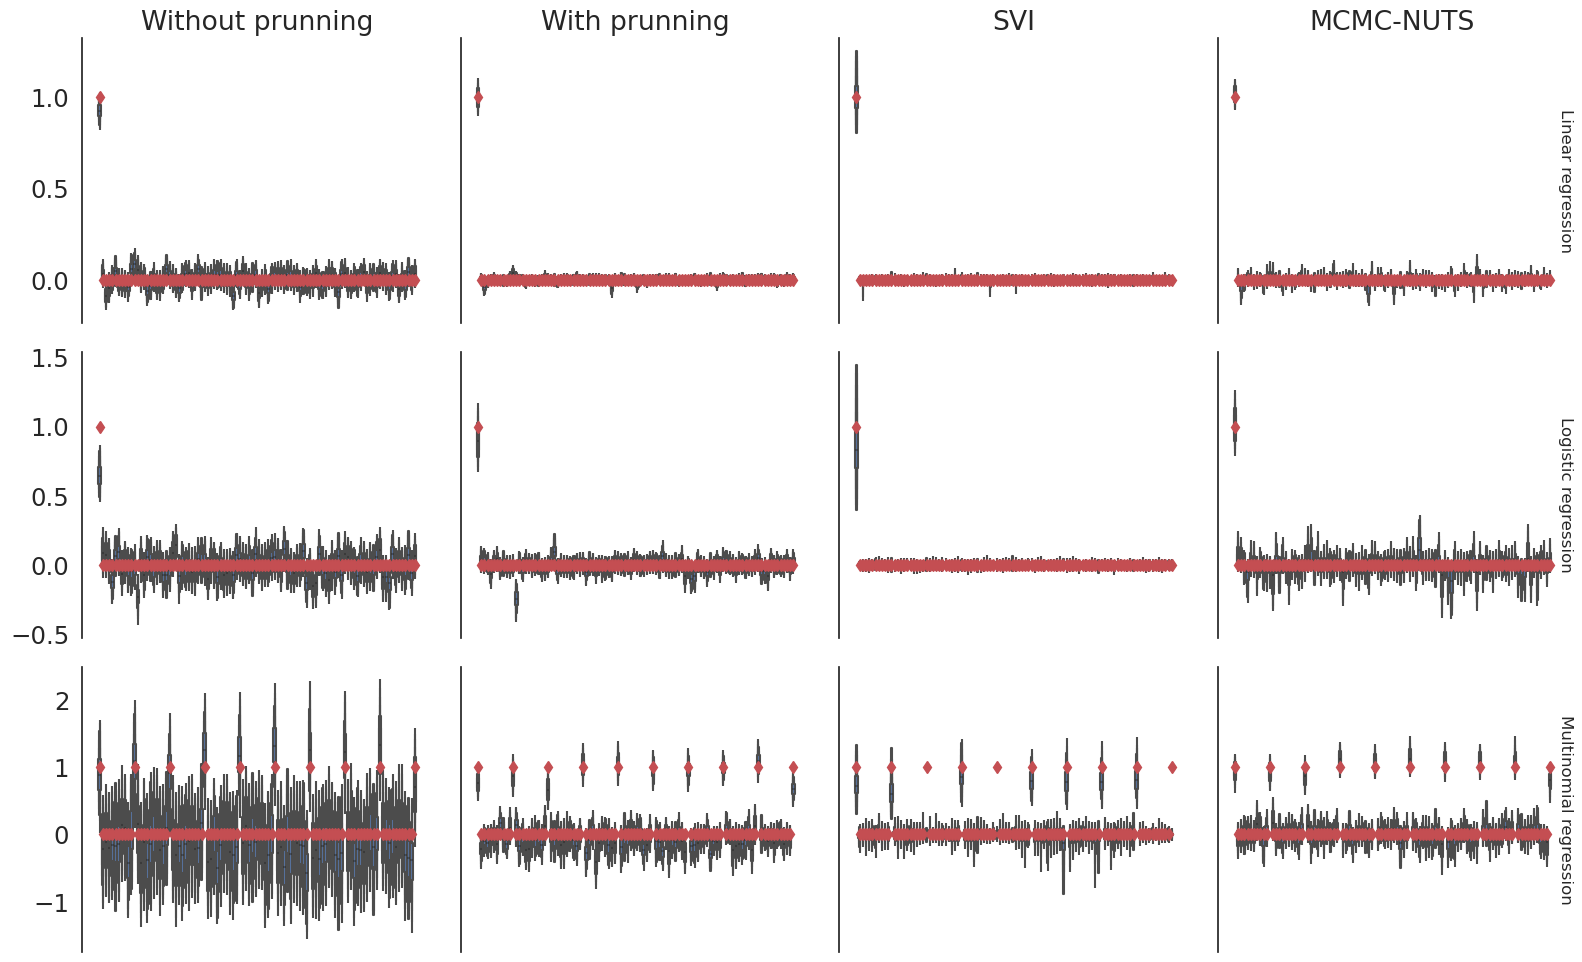

In [29]:
fig = plot_posteriors(nonlin_posterior)

## Linearized network

In [12]:
svi_reg = LinearizedRegression(_rng_key, X_norm, nnet1, regtype='linear', posterior='normal', with_hyperprior=False)
svi_smpl_norm = svi_reg.fit(
    y_norm, 
    num_steps=200_000, 
    num_particles=10, 
    autoguide='test', 
    progress_bar=True
)
nonlin_posterior['svi']['norm'] = svi_smpl_norm['beta']

100%|██████████| 200000/200000 [02:44<00:00, 1214.05it/s, init loss: 7067.4751, avg. loss [190001-200000]: 8306.7930]


In [13]:
rng_key, _rng_key = random.split(rng_key)
svi_reg = LinearizedRegression(_rng_key, X_bern, nnet1, regtype='logistic', with_hyperprior=False)
svi_smpl_bern = svi_reg.fit(
    y_bern, 
    num_steps=200_000, 
    autoguide='test', 
    progress_bar=True
)
nonlin_posterior['svi']['bern'] = svi_smpl_bern['beta']

 45%|████▍     | 89933/200000 [01:25<01:33, 1178.04it/s, init loss: 4923.3115, avg. loss [70001-80000]: 4618.9272]

In [ ]:
rng_key, _rng_key = random.split(rng_key)
svi_reg = SVIRegression(_rng_key, X_cat, nnet2, regtype='multinomial', with_hyperprior=False)
svi_smpl_cat = svi_reg.fit(
    y_cat, 
    num_steps=200_000, 
    num_particles=10, 
    autoguide='test', 
    progress_bar=True
)
over_posterior['svi']['cat'] = svi_smpl_cat['beta']

100%|██████████| 200000/200000 [03:58<00:00, 839.64it/s, init loss: 4155.0620, avg. loss [190001-200000]: 4728.7871]


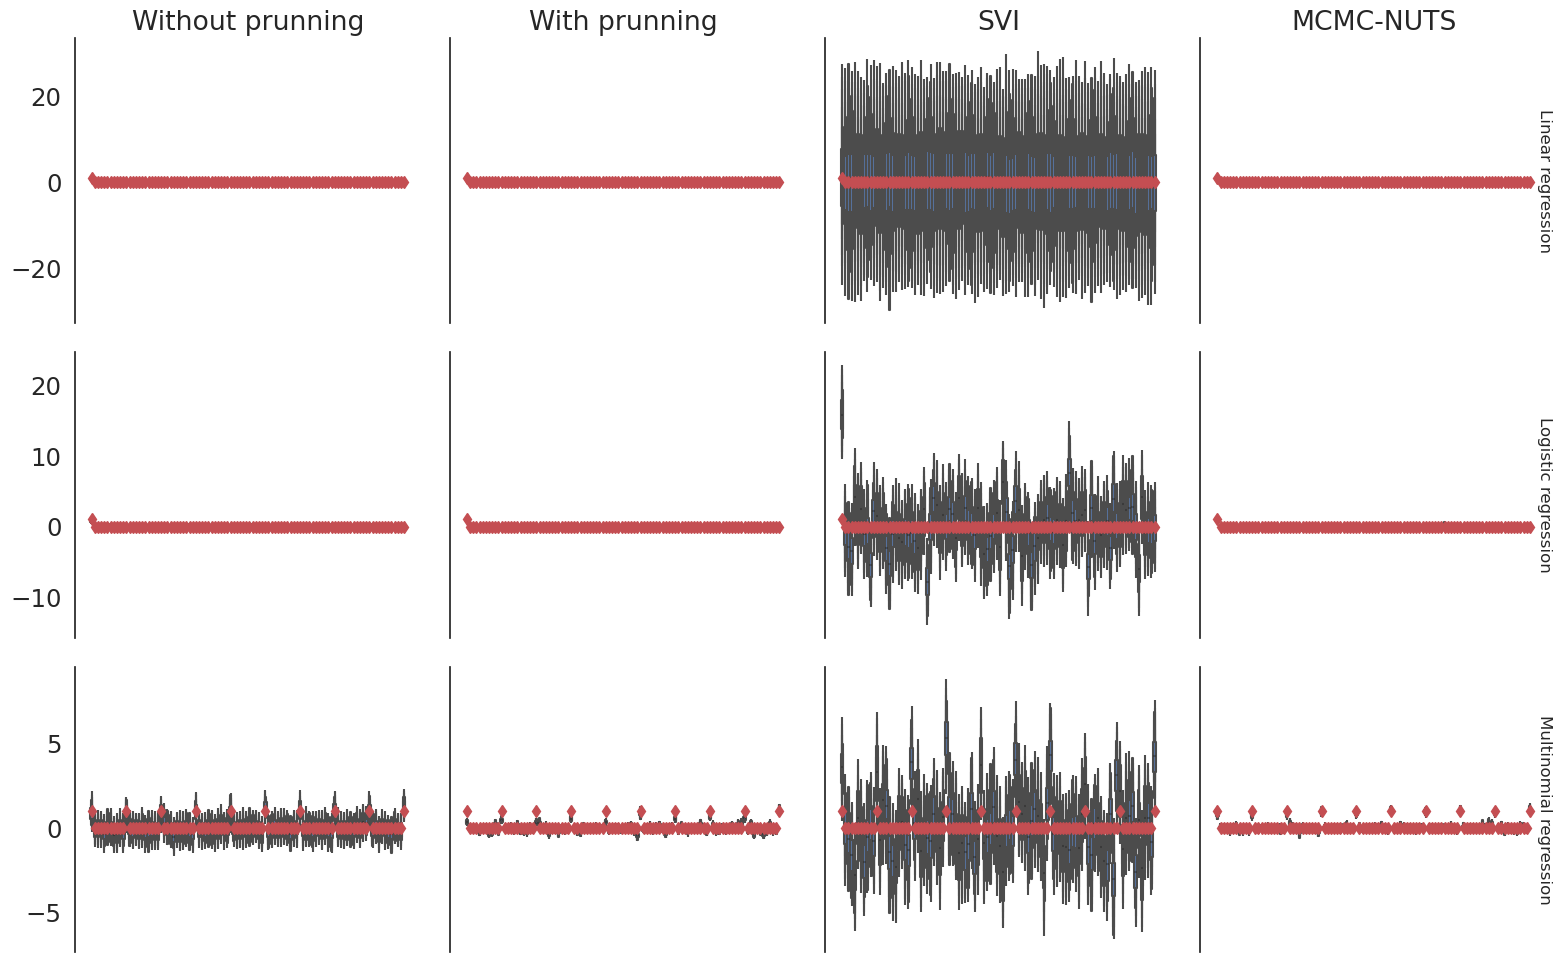

In [ ]:
fig = plot_posteriors(over_posterior)